In [13]:
#@title **Librerías Utilizadas**:

import tensorflow.keras as keras
from keras.models import Sequential
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D
from keras.datasets import cifar10
from keras import regularizers, optimizers
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Add
from keras.layers import Input
from keras.models import Model 
from keras.layers import Reshape
from keras.layers import multiply
from google.colab import drive
from tensorflow.keras.regularizers import l2

from keras import backend as K
from keras.utils.vis_utils import plot_model
from keras.preprocessing.image import array_to_img
import tensorflow as tf
import cv2
from IPython.display import Image, display
import matplotlib.cm as cm
from keras.applications.imagenet_utils import preprocess_input

In [2]:
#@title **Building the Channel Attention Module:**

def ch_attention(input_t, ratio=8):
  inputs = input_t
  channel_axis = 1 if K.image_data_format() == 'channel_first' else -1
  filters = inputs.shape[channel_axis]

  # Define shared MLP
  # Double // to obtain an int after division
  MLP_Layer_S1 = Dense(filters//ratio, activation='relu',kernel_initializer='he_normal', use_bias=True, bias_initializer='zeros')# W0
  MLP_Layer_S2 = Dense(filters, activation='relu',kernel_initializer='he_normal', use_bias=True, bias_initializer='zeros')# W1

  # Average-pooled features
  avg_pool = GlobalAveragePooling2D()(inputs)
  avg_pool = Reshape((1,1,filters))(avg_pool)
  avg_pool = MLP_Layer_S1(avg_pool)
  avg_pool = MLP_Layer_S2(avg_pool)

  # Max-pooled features
  max_pool = MaxPooling2D()(inputs)
  max_pool = Reshape((1,1,filters))(max_pool)
  max_pool = MLP_Layer_S1(max_pool)
  max_pool = MLP_Layer_S2(max_pool)

  # Element-wise summation of two last vectors and sigmoid act function
  cbam_feat_ch = Add()([avg_pool, max_pool])
  cbam_feat_ch = Activation('sigmoid')(cbam_feat_ch)
  cbam_feat_ch = Multiply([inputs,cbam_feat_ch])
  return cbam_feat_ch

In [3]:
#@title **Building the Spatial Attention Module:**

def sp_attention(input_t, kernel_size=7):
  inputs = input_t
  avg_pool = Lambda(lambda x: K.mean(x, axis=3, keepdims=True))(inputs)#se hace para cada canal por separado axis=0
  #axis=3 solo para los canales
  max_pool = Lambda(lambda x: K.max(x, axis=3, keepdims=True))(inputs)
  concat = Concatenate(axis=-1)([avg_pool, max_pool])
  cbam_feat_sp = Conv2D(filters=1, kernel_size=kernel_size, strides=1, padding='same', activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(concat)
  cbam_feat_sp = Multiply([inputs,cbam_feat_sp])
  return cbam_feat_sp

In [4]:
#@title **Complete CBAM:**

def cbam_block(input_t):
  init = input_t
  cbam_feat_ch = ch_attention(init)
  cbam_feat_sp = sp_attention(cbam_feat_ch)
  return cbam_feat

In [5]:
#@title **Bloque inicial:**
# Dada la baja resolucion de las img cifar10, vamos a utilizar stride 1
# En lugar de 2 como es sugerido en la resnet original

def initial_conv(Input, filters, stride=1, kz=7):
  x = Conv2D(filters, kernel_size=(kz,kz), strides=(stride,stride),
             padding='same', use_bias=False, kernel_initializer='he_normal',
             kernel_regularizer=l2(1e-4))(Input)

  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  return x

In [6]:
#@title **bottleneck residual block:**
# Conv Block es un bottleneck residual block. Empieza con una convolucion de 1*1
# que reduce el depth, seguido por una de 3x3 y la ultima de 1*1 usada para
# restaurar la depth

def conv_block(Input, filters, se, stride=1):
  
  # Bloque para contraer a 1*1
  x = Conv2D(filters, kernel_size=(1,1), strides=(stride, stride), padding='same',kernel_initializer='he_normal',
                      use_bias=False)(Input)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  # Bloque para preservar  3*3 convol.
  x = Conv2D(filters,kernel_size=(3,3),strides=(stride,stride),padding='same',kernel_initializer='he_normal',
                      use_bias=False)(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  # Bloque para expandir a 1*1
  x = Conv2D(filters*4, kernel_size=(1,1), strides=(stride, stride), padding='same',kernel_initializer='he_normal',
                      use_bias=False)(x)
  x = BatchNormalization()(x)
  #x = Activation('relu')(x)

  # Bloque de proyeccion
  skip_conv = Conv2D(filters*4, kernel_size=(1,1), strides=(stride,stride), padding='same',kernel_initializer='he_normal',
                      use_bias=False)(Input)
  skip = BatchNormalization()(skip_conv)

  # Bloque squeeze and excite
  if se==True:
    x = squeeze_excite_block(x)

  # Sumar los dos bloques
  x = Add()([x,skip])

  return x

In [7]:
#@title **Bloque identidad:**

def ident_block(Input, filters, se, stride = 1):

  # x = BatchNormalization()(Input)
  # x = Activation('relu')(x)
  # Bloque para contraer a 1*1
  x = Conv2D(filters, kernel_size=(1,1), strides=(stride, stride), padding='same',kernel_initializer='he_normal',
                      use_bias=False)(Input)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  # Bloque para preservar  3*3 convol.
  x = Conv2D(filters,kernel_size=(3,3),strides=(stride,stride),padding='same',kernel_initializer='he_normal',
                      use_bias=False)(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  # Bloque para expandir a 1*1
  x = Conv2D(filters*4, kernel_size=(1,1), strides=(stride, stride), padding='same', kernel_initializer='he_normal',
                      use_bias=False)(x)
  x = BatchNormalization()(x)
  #x = Activation('relu')(x)

  # Bloque squeeze and excite
  #if se==True:
   # x = squeeze_excite_block(x)

  # Bloque identidad sumado
  x = Add()([x,Input])

  return x

In [8]:
#@title **Crear la resNet 50:**

def build_resnet50(h,w, n_outputs,r1, r2, r3,r4, se, first_conv_stride=2, first_conv_kernel_size=7):
  # Crear el tensor de entrada
  inputs = Input(shape = (h,w,3), name = 'image_input')

  # Bloque inicial
  x = initial_conv(inputs,64,first_conv_stride,first_conv_kernel_size)
  x = MaxPooling2D(pool_size=(3, 3),strides=(2,2), padding='same')(x)
  #x = MaxPooling2D(pool_size=(2,2))(x)
  
  # Bloque de convolucion 1
  #if se==True:
  #  x = conv_block(x,64,True,1)  
  #else:
  x = conv_block(x,64,False,1)
  x = Activation('relu')(x)
  
  # Repitiendo el bloque identidad
  for i in range(r1-1):
    if se==True:
      x = ident_block(x,64, True)
    else:
      x = ident_block(x,64, False)
    x = Activation('relu')(x)
  
  # Bloque de convolucion 2
  #if se==True:
  #  x = conv_block(x,128,True, 2)  
  #else:
  x = conv_block(x,128,False,1)
  x = Activation('relu')(x)
  
  # Repitiendo el bloque identidad
  for i in range(r2-1):
    if se==True:
      x = ident_block(x,128, True)
    else:
      x = ident_block(x,128, False)
    x = Activation('relu')(x)
    
  # Bloque de convolucion 3
  #if se==True:
  #  x = conv_block(x,256,True,2)   
  #else:
  x = conv_block(x,256,False,1)
  x = Activation('relu')(x)
  
  # Repitiendo el bloque identidad
  for i in range(r3-1):
    if se==True:
      x = ident_block(x,256, True)
    else:
      x = ident_block(x,256, False)
    x = Activation('relu')(x)
    
  # Bloque de convolucion 4
  #if se==True:
  #  x = conv_block(x,512,True,2)  
  #else:
  x = conv_block(x,512,False,1)
  x = Activation('relu')(x)
  
  # Repitiendo el bloque identidad
  for i in range(r4-1):
    if se==True:
      x = ident_block(x,512, True)
    else:
      x = ident_block(x,512, False)
    x = Activation('relu')(x)
  
  #x = BatchNormalization()(x)
  #x = Activation('relu')(x)
  shape = K.int_shape(x)

  x = AveragePooling2D(pool_size=([shape[1],shape[2]]), strides=(1,1))(x)

  x = Flatten()(x)
  x = Dense(n_outputs, activation = 'softmax')(x)

  model = Model(inputs = inputs, outputs = x)
  return model

In [9]:
#@title **Crea el model_cbam:**

model_cbam = build_resnet50(32,32,10,3,4,6,3,True,1,7)

In [10]:
#@title **Cargar Variables del Dataset:**

(x_train, y_train), (x_test, y_test)=cifar10.load_data()

170508288/170498071 [==============================] - 4s 0us/step


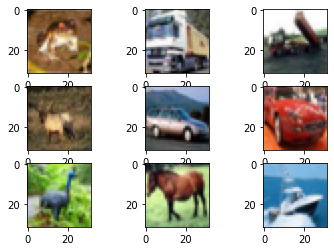

In [14]:
#@title **Visualizar los archivos:**

for i in range(0,9):
  plt.subplot(3,3,i+1)
  plt.imshow(array_to_img(x_train[i]))
plt.show()

In [15]:
#@title **Cambiar el tipo de dato a flotante, Normalización:**

x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

mean =np.mean(x_train, axis=(0,1,2,3))
std = np.std(x_train, axis=(0,1,2,3))

x_train = (x_train-mean)/(std + 1e-7)
x_test = (x_test-mean)/(std + 1e-7)

In [16]:
#@title **One hot encoding:**

num_classes = 10
y_train = np_utils.to_categorical(y_train, num_classes)
y_test = np_utils.to_categorical(y_test, num_classes)

In [18]:
#@title **Entrenamiento:**

adam = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999,
                            epsilon=None, decay=1e-6, amsgrad=False)

model_cbam.compile(loss='categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])
batch_size = 64
epochs = 10
history3 = model_cbam.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, 
                         validation_data=(x_test, y_test), verbose=1)

model_cbam.save("modelcbam.h5")
model_cbam.save_weights("modelcbamEwght.h5")
print("Modelo guardado en el PC")

Epoch 1/10
 44/782 [>.............................] - ETA: 11:26:45 - loss: 2.1734 - accuracy: 0.2578

KeyboardInterrupt: ignored

In [ ]:
#@title **Gráficar Accuracy y loss:**

### Gráfica de Accuracy
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

### Gráfica loss
plt.subplot(1,2,2)
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
#@title **Algortimo de GradCAM para visualización:**
#Author: fchollet
#Libro: Deep Learning with Python (2017)
#Description: How to obtain a class activation heatmap for an image classification model.

def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [ ]:
#@title **Cargar modelo:**

model_cbam = keras.models.load_model('modelcbam.h5')
#model_cbam.load_weights('modelcbamwght.h5')

# Con ADAM Modificado

#model_cbam = keras.models.load_model('modelcbamAdam.h5')
#model_cbam.load_weights('modelcbamwghtAdam.h5')

In [ ]:
#@title **Etiquetas CIFAR10:**

etiquetas = np.array([
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck'])

img_array = preprocess_input(get_img_array('caballo1.jpg', size=(32,32)))
img_array = img_array.astype('float32')/255.0
mean = np.mean(img_array, axis=(0,1,2,3))
std = np.std(img_array, axis=(0,1,2,3))
img_array = (img_array - mean)/(std+1e-7)
preds1 = model_cbam.predict(img_array)
#preds2 = model_cbamAdam.predict(img_array)

print(str(etiquetas[(np.argmax(preds1,axis=1))[0]]))
#print(str(etiquetas[(np.argmax(preds2,axis=1))[0]]))

heatmap1 = make_gradcam_heatmap(img_array, model_cbam, 'activation_48')
#heatmap2 = make_gradcam_heatmap(img_array, model_cbamAdam, 'activation_97')

plt.matshow(heatmap1)
plt.show
#print()
#plt.matshow(heatmap2)
#plt.show

In [ ]:
#@title **Porcentajes de valores:**

def save_and_display_gradcam(img_path, heatmap, cam_path, alpha=0.4):

    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))

In [ ]:
#@title **Resultado valores Gradcam:**

save_and_display_gradcam('caballo1.jpg', heatmap1, 'caballo1_CBAM.jpg')
#print()
#save_and_display_gradcam('caballo1.jpg', heatmap2, 'caballo1_CBAMAdam.jpg')